In [1]:
!pip install einops

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


# Integrating CNN to Transformer

In [23]:
from PIL import Image
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


def load_images(folder_path, threshold=None):
    """
    Load TIFF images and optional thresholding for masks without downsampling.
    
    Args:
        folder_path (str): Path to the folder containing TIFF images.
        threshold (int, optional): Threshold value for binary masks. Default is None.
        
    Returns:
        np.ndarray: Array of original images.
    """
    tiff_files = [f for f in os.listdir(folder_path) if f.endswith('.tif') or f.endswith('.tiff')]
    images = []  # Store original images

    for file_name in tiff_files:
        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path)  # Load the image
        image_array = np.array(image)  # Convert to NumPy array

        # Apply threshold for binary masks (if provided)
        if threshold is not None:
            image_array = (image_array > threshold).astype(np.uint8)
            
        # Ensure the image is 256x256, or resize if necessary
        if image_array.shape != (256, 256):
            # Split the image into 4 quarters
            top_left = image[:256, :256]  # Top-left quarter
            top_right = image[:256, 256:]  # Top-right quarter
            bottom_left = image[256:, :256]  # Bottom-left quarter
            bottom_right = image[256:, 256:]  # Bottom-right quarter

            # Stack the quarters to form a (4, 128, 128) array
            quarters_image = np.stack([top_left, top_right, bottom_left, bottom_right])
            # Append the quarters image to the list
            for i in range(4):
                images.append(quarters_image[i])   
        else: 
            images.append(image_array)  # Store the original image

    return np.stack(images).astype(np.float32)  # Return as a single NumPy array


def load_and_downsample_images(folder_path, threshold = None):
    tiff_files = [f for f in os.listdir(folder_path) if f.endswith('.tif') or f.endswith('.tiff')]
    original_images = []  # Store original images

    for file_name in tiff_files:
        file_path = os.path.join(folder_path, file_name)
        image = np.array(Image.open(file_path))#.convert("L")  # Convert to grayscale
        image_array = np.array(image)  # Convert to NumPy array

        # Apply threshold for binary masks (if provided)
        if threshold is not None:
            image_array = (image_array > threshold).astype(np.uint8)
            
        # Ensure the image is 256x256, or resize if necessary
        if image.shape != (256, 256):
            # Split the image into 4 quarters
            top_left = image[:256, :256]  # Top-left quarter
            top_right = image[:256, 256:]  # Top-right quarter
            bottom_left = image[256:, :256]  # Bottom-left quarter
            bottom_right = image[256:, 256:]  # Bottom-right quarter

            # Stack the quarters to form a (4, 128, 128) array
            quarters_image = np.stack([top_left, top_right, bottom_left, bottom_right])
            # Append the quarters image to the list
            for i in range(4):
                original_images.append(quarters_image[i])
            
        else: 
            original_images.append(np.array(image))  # Store the original image

    return np.stack(original_images).astype(np.float32) 


In [24]:
# Paths to data
# Paths to data
brightfield_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/test/brightfield'
masks_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/test/masks'

# Load brightfield images and masks
original_brightfield = load_and_downsample_images(brightfield_folder)
original_masks = load_and_downsample_images(masks_folder, threshold = 1)


# Convert images and masks to PyTorch tensors
X_tensor = torch.tensor(original_brightfield, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
Y_tensor = torch.tensor(original_masks, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

dataset = TensorDataset(X_tensor, Y_tensor)  # Pairs of images and masks
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)  # Modify batch size if needed

#TODO: We need to add validation data!

# Check shapes
print(f"Original Brightfield Tensor Shape: {X_tensor.shape}")  # Expected: (batch_size, 1, H, W)
print(f"Original Masks Tensor Shape: {Y_tensor.shape}")        # Expected: (batch_size, 1, H, W)


Original Brightfield Tensor Shape: torch.Size([20, 1, 256, 256])
Original Masks Tensor Shape: torch.Size([20, 1, 256, 256])


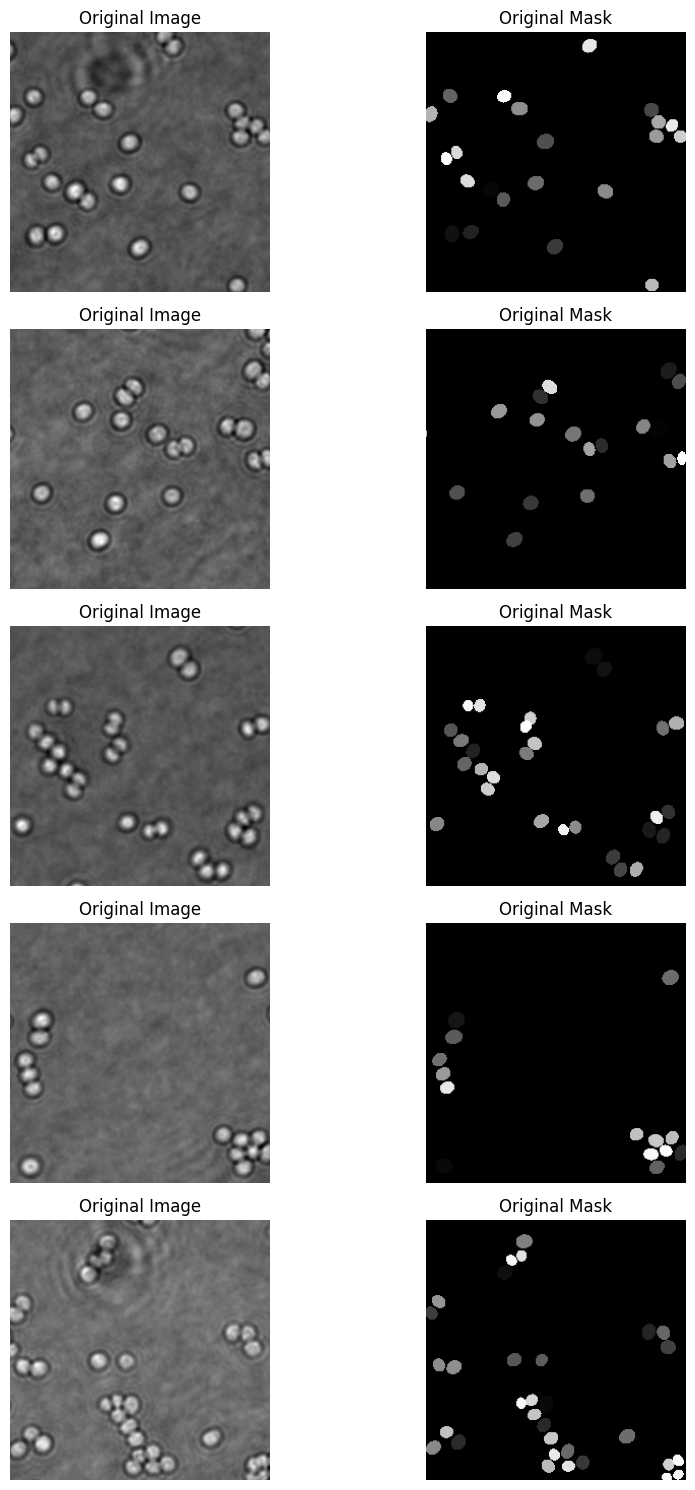

In [25]:
import matplotlib.pyplot as plt

num_examples = 5  # Number of examples to display
plt.figure(figsize=(10, num_examples * 3))

for i in range(num_examples):
    plt.subplot(num_examples, 2, i * 2 + 1)
    plt.imshow(original_brightfield[i], cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(num_examples, 2, i * 2 + 2)
    plt.imshow(original_masks[i], cmap="gray")
    plt.title("Original Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


## CNN Feature Extractor

In [26]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, output_channels=64):
        super(CNNFeatureExtractor, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # First Conv Layer
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample by 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Second Conv Layer
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample by 2
            nn.Conv2d(64, output_channels, kernel_size=3, stride=1, padding=1),  # Final Conv Layer
            nn.BatchNorm2d(output_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.cnn(x)
    

## Transformer

In [27]:
class SimpleTransformer(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, num_heads, num_layers, cnn_extractor):
        super(SimpleTransformer, self).__init__()
        self.cnn_extractor = cnn_extractor
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.position_embedding = None
        self.transformer = nn.Transformer(embed_dim, num_heads, num_layers, num_layers)
        self.head = nn.Linear(embed_dim, patch_size * patch_size)

        # Upsampling layer to match target size
        self.upsample = nn.Upsample(scale_factor=0.5, mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.cnn_extractor(x)  # (B, C, H, W)
        B, C, H, W = x.shape
        #print(f"[DEBUG] CNN Output Shape: {x.shape}")

        x = rearrange(x, 'b c h w -> b (h w) c')  # (B, num_patches, embed_dim)
        num_patches = x.size(1)

        if self.position_embedding is None or self.position_embedding.size(1) != num_patches:
            self.position_embedding = nn.Parameter(torch.randn(1, num_patches, self.embed_dim).to(x.device))

        x = x + self.position_embedding
        x = self.transformer(x, x)
        #print(f"[DEBUG] Transformer Output Shape: {x.shape}")

        h_patches = w_patches = int(num_patches ** 0.5)
        x = self.head(x)
        x = rearrange(x, 'b (h_patches w_patches) (p1 p2) -> b 1 (h_patches p1) (w_patches p2)',
                      h_patches=h_patches, w_patches=w_patches, p1=self.patch_size, p2=self.patch_size)
        #print(f"[DEBUG] Rearranged Output Shape: {x.shape}")

        # Upsample to match target size
        x = self.upsample(x)
        #print(f"[DEBUG] Final Upsampled Output Shape: {x.shape}")
        return x

## Visualization Code

In [28]:
# Function to visualize predictions
def visualize_predictions(images, masks, outputs, num_examples=4):
    """
    Visualize a few examples of the input images, ground truth masks, and model predictions.

    Args:
        images (torch.Tensor): Input images.
        masks (torch.Tensor): Ground truth masks.
        outputs (torch.Tensor): Model predictions.
        num_examples (int): Number of examples to visualize.
    """
    # Convert tensors to CPU for visualization
    images = images[:num_examples].cpu().numpy()
    masks = masks[:num_examples].cpu().numpy()
    outputs = torch.sigmoid(outputs[:num_examples]).cpu().numpy()  # Apply sigmoid to get probabilities

    # Plot the results
    fig, axes = plt.subplots(num_examples, 3, figsize=(12, num_examples * 4))
    for i in range(num_examples):
        # Input image
        axes[i, 0].imshow(images[i, 0], cmap="gray")
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis("off")

        # Ground truth mask
        axes[i, 1].imshow(masks[i, 0], cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        # Model prediction
        axes[i, 2].imshow(outputs[i, 0], cmap="gray")
        axes[i, 2].set_title("Model Prediction")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

## Training

Epoch 50, Loss: -3.3315


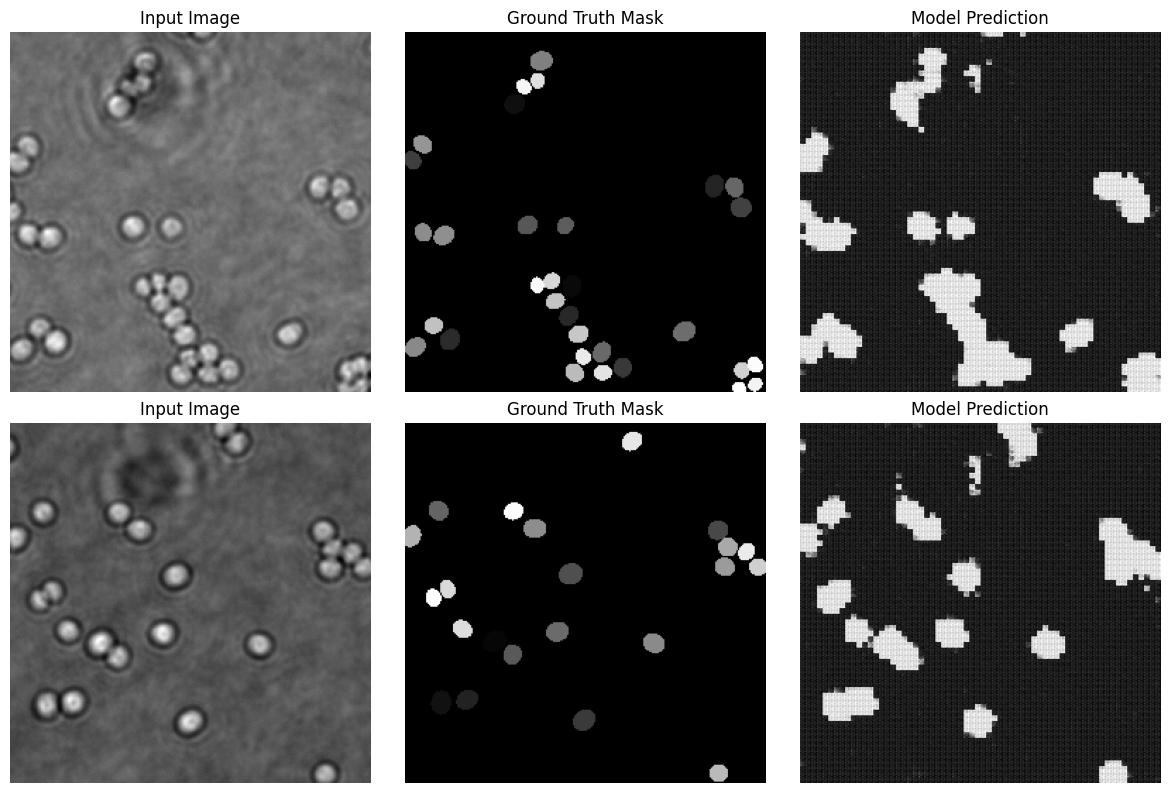

KeyboardInterrupt: 

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the CNN
cnn_extractor = CNNFeatureExtractor(output_channels=64)

# Initialize the Transformer with CNN as backbone
model = SimpleTransformer(img_size=64, patch_size=8, embed_dim=64, num_heads=4, num_layers=4, cnn_extractor=cnn_extractor).to(device)

# Train the model
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()
num_epochs = 500
training_loss = []

# Save Model File
best_loss = float('inf')  
best_model_path = "best_model_TransformerCNN_trial.pth"  


for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    for images, masks in dataloader:  # Assuming dataloader includes all data
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(dataloader)
    training_loss.append(avg_loss)
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), best_model_path)
        
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")
    
    if (epoch + 1) % 50 == 0:
    # Visualize predictions after each epoch (optional)
        model.eval()
        with torch.no_grad():
            for images, masks in dataloader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                visualize_predictions(images, masks, outputs, num_examples=2) # Change num examples if more visuals are wanted
                break  # Visualize only the first batch
                
    # Store all Images, Masks, Outputs at the last epoch
    if epoch == num_epochs - 1:
        model.eval()
        all_images = []
        all_masks = []
        all_outputs = []
        with torch.no_grad():
            for images, masks in dataloader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                all_images.append(images.cpu())
                all_masks.append(masks.cpu())
                all_outputs.append(outputs.cpu())
        
        # Concatenate and save as tensors
        all_images = torch.cat(all_images, dim=0)
        all_masks = torch.cat(all_masks, dim=0)
        all_outputs = torch.cat(all_outputs, dim=0)



(0.0, 4000.0)

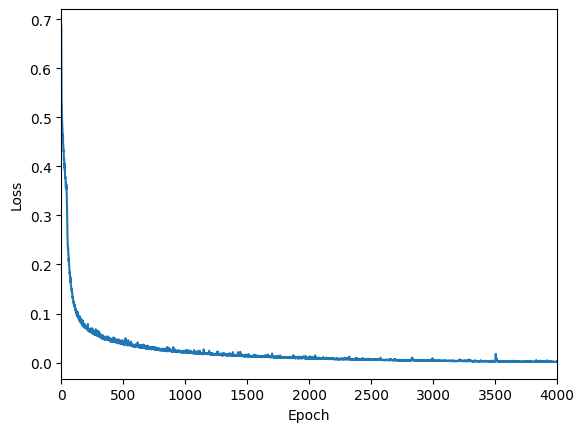

In [12]:
# Plot Training Performance vs. Epochs

plt.plot(range(num_epochs), training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim((0, num_epochs))


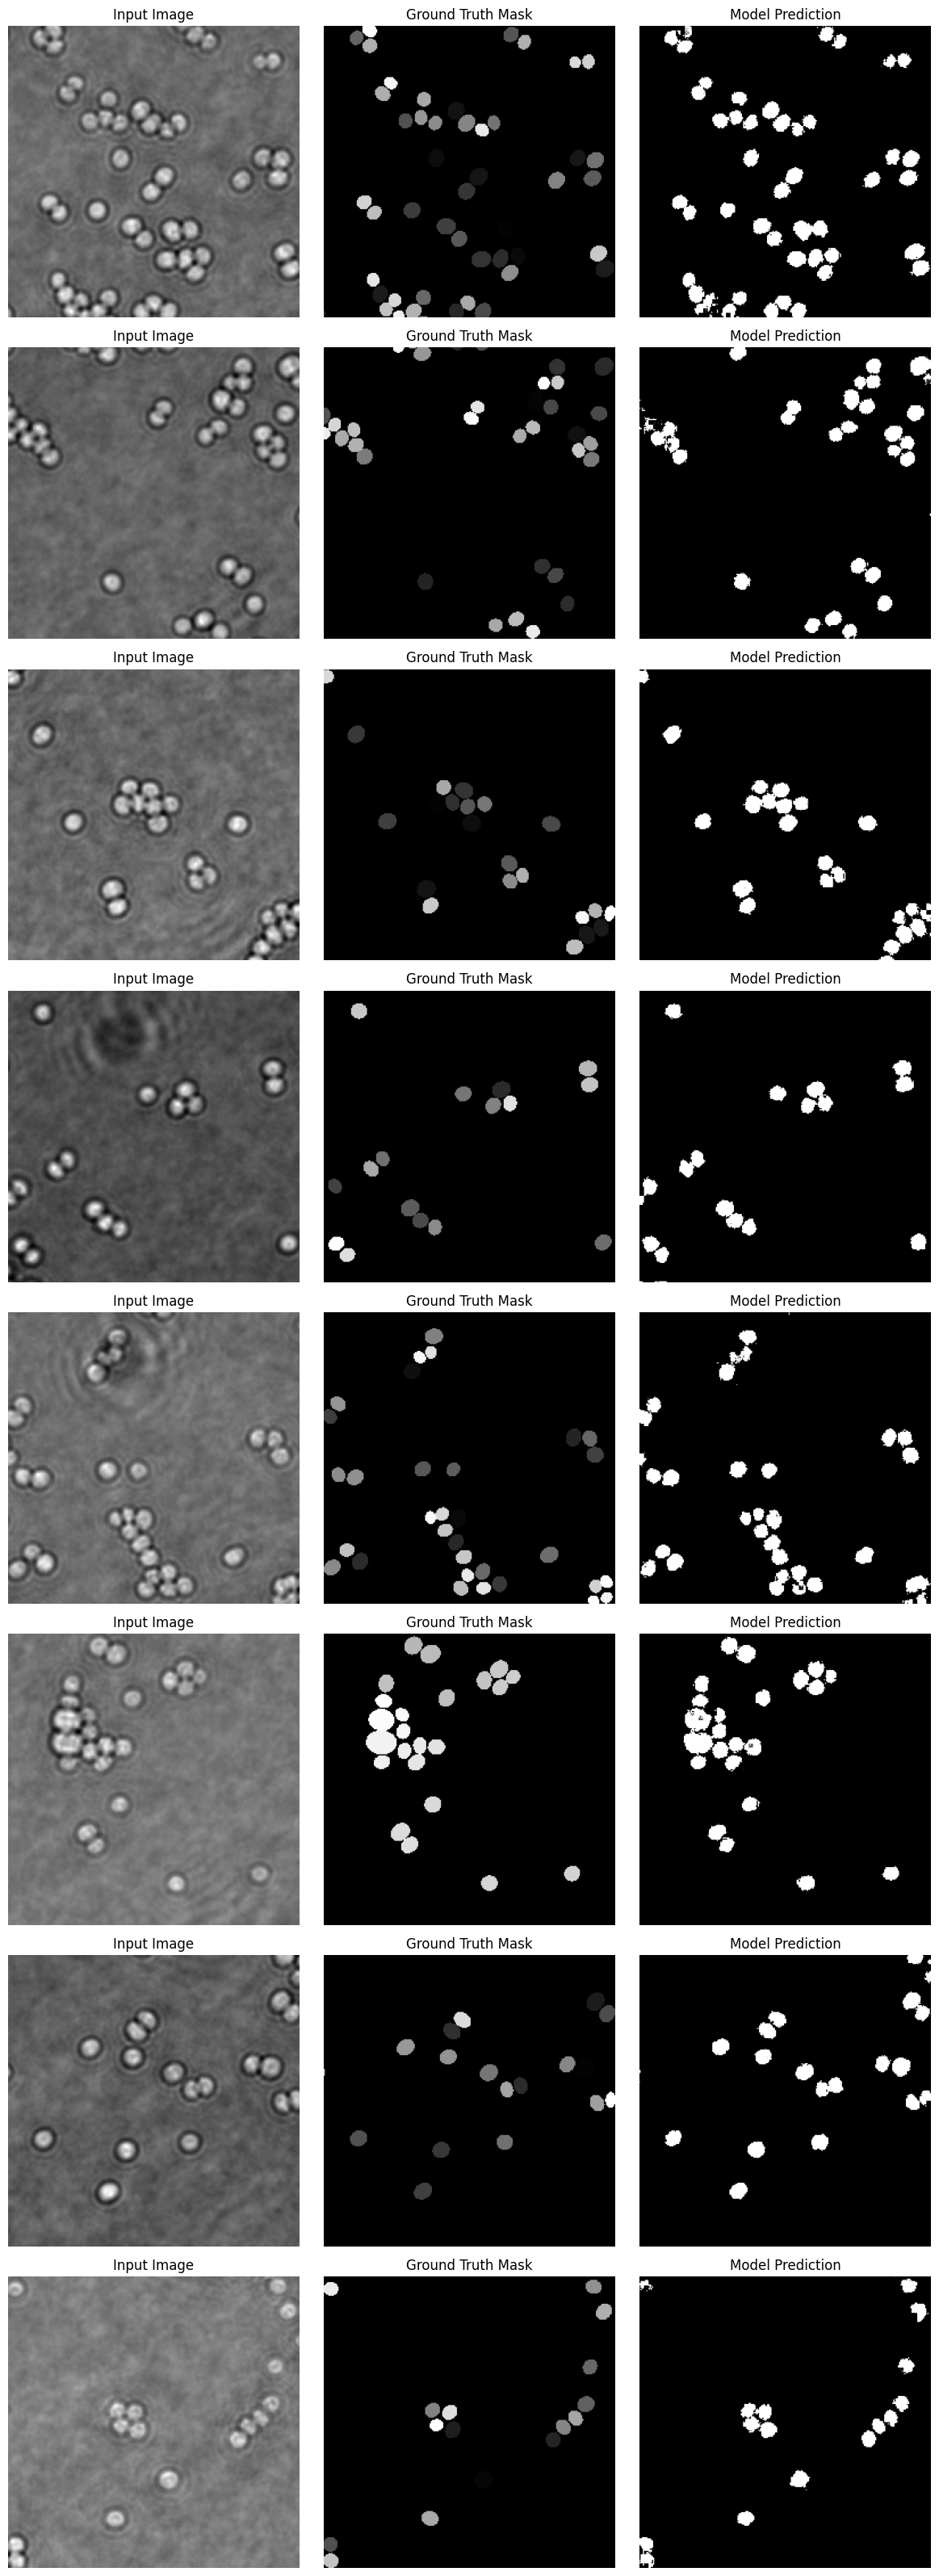

In [30]:
# Visualize the first batch of the best performing model weights on training set
# Load model: 

model.load_state_dict(torch.load(f'best_model_TransformerCNN_12000.pth'))
model.eval()
with torch.no_grad():
    for images, masks in dataloader:  
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        visualize_predictions(images, masks, outputs, num_examples=8)
        break


## **Testing**

In [31]:
# Load Test Data

# Paths to data
brightfield_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/test/brightfield'
masks_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/test/masks'

# Load brightfield images and masks
original_brightfield = load_and_downsample_images(brightfield_folder)
original_masks = load_and_downsample_images(masks_folder)

# Convert images and masks to PyTorch tensors
X_tensor = torch.tensor(original_brightfield, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
Y_tensor = torch.tensor(original_masks, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

test_dataset = TensorDataset(X_tensor, Y_tensor)  # Pairs of images and masks
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)  # Modify batch size if needed

# Check shapes
print(f"Test - Original Brightfield Tensor Shape: {X_tensor.shape}")  # Expected: (batch_size, 1, H, W)
print(f"Test - Original Masks Tensor Shape: {Y_tensor.shape}")        # Expected: (batch_size, 1, H, W)

Test - Original Brightfield Tensor Shape: torch.Size([20, 1, 256, 256])
Test - Original Masks Tensor Shape: torch.Size([20, 1, 256, 256])


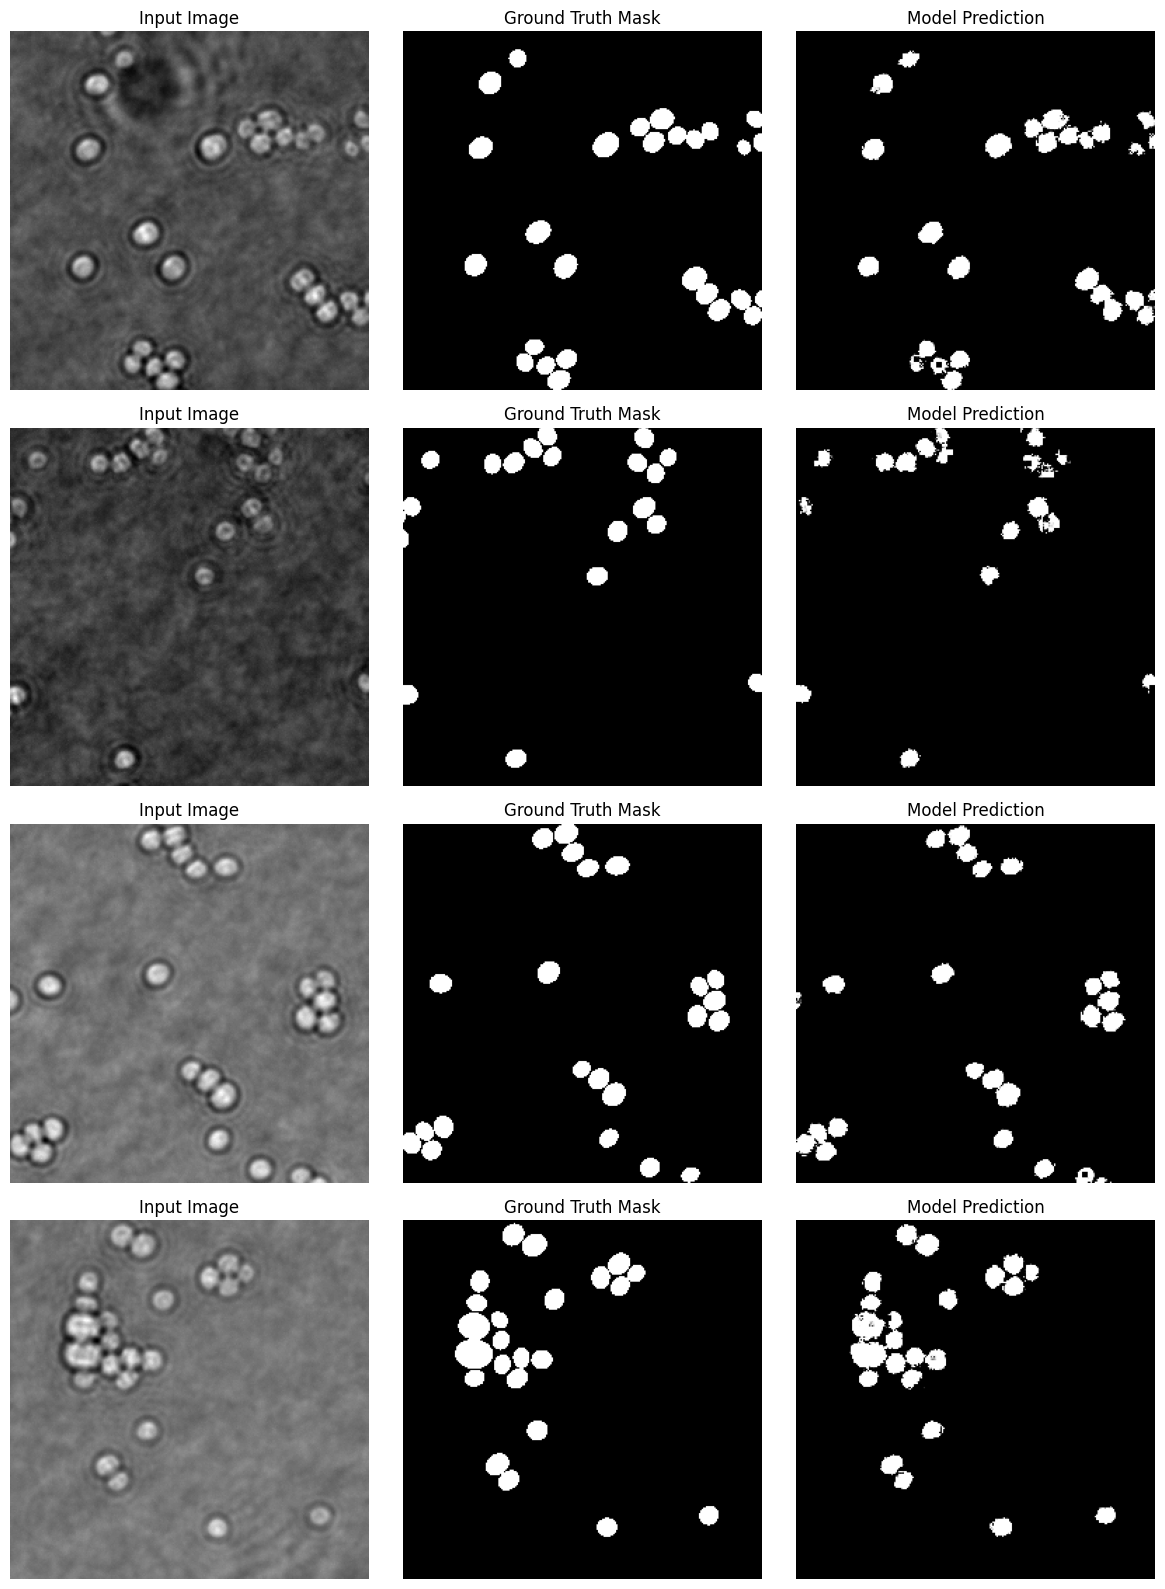

Loss: 0.15532601873079935
Stored all images, masks, and outputs.


In [49]:
# Test Model 

# Initialize lists to store results
all_images = []
all_masks = []
all_bin_masks = []
all_outputs = []

model.eval()
total_loss = 0.0

with torch.no_grad():
    for images, masks in test_dataloader:  # Assuming dataloader includes all data
        images, masks = images.to(device), masks.to(device)
        
        threshold = 0.5  # Example threshold for binary mask

        # Binarize the tensor
        bin_masks = (masks > threshold).float()    
        
        # Forward pass
        outputs = model(images)  # Predictions
        loss = criterion(outputs, bin_masks)  # Loss calculation
        total_loss += loss.item()
        
        # Store images, masks, and outputs
        all_images.append(images.cpu())        # Move to CPU to avoid GPU memory issues
        all_masks.append(masks.cpu())
        all_bin_masks.append(bin_masks.cpu())
        all_outputs.append(outputs.cpu())
        
    # Visualize a few predictions (optional)
    visualize_predictions(images, bin_masks, outputs, num_examples=4)
        
    # Calculate and print average loss
    avg_loss = total_loss / len(test_dataloader)
    print('Loss:', avg_loss)

# Optional: Concatenate results for easy access
all_images = torch.cat(all_images, dim=0)
all_masks = torch.cat(all_masks, dim=0)
all_bin_masks = torch.cat(all_bin_masks, dim=0)
all_outputs = torch.cat(all_outputs, dim=0)


print("Stored all images, masks, and outputs.")


## Segmentation / Bounding Boxes

**Functions**

## Get Bounding Boxes for Instance Masks, then combine

In [100]:
## Functions for getting Instance Masks 

def get_instance_masks(image, plot = None): # Plot Masks - plot = 1
    Masks = []
    image = image.cpu().numpy().squeeze(0)
    
    cell_count, cell_colors = get_cell_count(image)
    
    # Create mask for each Cell: 
    for cell in range(cell_count):

        # Cell Color
        color = cell_colors[cell]
        
        if color != 0:
            # Find Pixels
            cell_indices = (image.flatten() == color)

            # Form mask of cell in a 256x256 image with black background (all other pixels in image are colored 0)
            mask = np.zeros((image.shape[0]**2, 1), dtype=np.uint8)        
            mask[cell_indices] = 1


            #Here I do not believe that we need to keep thier original color. This gets tricky with classifcation because we go from 0 1 classification to essential regression down to the precision of N class aprx. 1/109 max prec.

            mask = mask.reshape((image.shape[0], image.shape[0]))

            if plot == 1:
                # Visualize the mask
                plt.figure()
                plt.imshow(mask, cmap="gray")
                plt.title(f"Mask for Cell {cell + 1}")
                plt.axis("off")
            Masks.append(mask)
            
    if len(Masks) < 109:
        for k in range(109-len(Masks)):
            mask = np.zeros((image.shape[0]**2, 1), dtype=np.uint8)  
            mask = mask.reshape((image.shape[0], image.shape[0]))
            Masks.append(mask)
    
    if len(Masks) > 109:
        return

    if plot == 1:
        plt.show()

    return Masks

def get_cell_count(image): 

    # Masked Image (256 x 256) 
    unique_colors = np.unique(image)
    cell_colors = unique_colors[unique_colors != 0]  # Exclude background (color 0)

    # Cell Count
    cell_count = len(cell_colors)    
    
    return cell_count, cell_colors

In [120]:
## Reconfigure Functions to do this 
import torch
import cv2
import numpy as np
from scipy.ndimage import label

def get_bounding_boxes(mask):
    """
    Extract bounding boxes from a binary mask.
    Input:
        mask: Binary mask (H x W), where objects are white (1) and background is black (0).
    Output:
        List of bounding boxes as (x, y, w, h).
    """
    # Convert to numpy and ensure binary format
    if isinstance(mask, np.ndarray):
        mask_np = mask
    else:
        mask_np = mask.squeeze().cpu().numpy().astype(np.uint8)  # Convert PyTorch tensor to NumPy
    
    # Ensure binary format
    mask_np = mask_np.astype(np.uint8)
    labeled_mask, num_objects = label(mask_np)  # Label connected components
    # print(num_objects)
    
    bounding_boxes = []
    for i in range(1, num_objects + 1):
        obj_mask = (labeled_mask == i).astype(np.uint8)
        contours, _ = cv2.findContours(obj_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes.append((x, y, w, h))
    
    return bounding_boxes


def compute_overlap(boxA, boxB):
    """
    Compute IoU (Intersection over Union) between two bounding boxes.
    Each box is (x, y, w, h).
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    # Compute the area of intersection
    interArea = max(0, xB - xA) * max(0, yB - yA)
    
    # Compute area of each box
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    
    # Compute IoU
    iou = interArea / float(boxAArea)
    return iou

def draw_bounding_boxes(image, boxes, indices_to_draw=None, color=(0, 255, 0), thickness=2):
    """
    Draw specific bounding boxes on an image.
    Input:
        image: Input mask or image as numpy array (H x W).
        boxes: List of bounding boxes [(x, y, w, h)].
        indices_to_draw: List of indices of boxes to be drawn (e.g., [0, 2, 3]).
                         If None, draw all bounding boxes.
        color: Bounding box color (BGR for OpenCV).
        thickness: Line thickness of the boxes.
    Output:
        Image with specified bounding boxes drawn.
    """
    image = image.copy()
    if len(image.shape) == 2:  # If grayscale, convert to 3-channel
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Draw only specified bounding boxes
    if indices_to_draw is None:
        indices_to_draw = range(len(boxes))  # Draw all boxes if none specified
    
    for idx in indices_to_draw:
        if idx < len(boxes):  # Ensure index is within bounds
            x, y, w, h = boxes[idx]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, thickness)
    return image


def calculate_recall(all_masks, all_outputs, overlap_threshold=0.75, indices_to_draw = None):
    """
    Calculate recall and visualize bounding boxes.
    Input:
        all_masks: Tensor of ground truth masks, shape [N, 1, H, W].
        all_outputs: Tensor of predicted masks, shape [N, 1, H, W].
        overlap_threshold: IoU threshold for TP.
    Output:
        Recall value and visualization of bounding boxes.
    """
    total_TP = 0
    total_GT_boxes = 0

    for idx, (gt_mask, pred_mask) in enumerate(zip(all_masks, all_outputs)):
        # Get Instance Masks 
        instance_masks = get_instance_masks(gt_mask)
        
        gt_boxes_masks = []
        for mask in range(len(instance_masks)):
            box_mask = get_bounding_boxes(instance_masks[mask])
            if box_mask:
                gt_boxes_masks.append(box_mask)
            
        gt_boxes_masks = np.array(gt_boxes_masks).squeeze(1)
        # Get bounding boxes
        # gt_boxes = get_bounding_boxes(gt_mask)
        # print(np.array(gt_boxes).shape)
        gt_boxes = gt_boxes_masks
        pred_boxes = get_bounding_boxes(pred_mask)
        
        total_GT_boxes += len(gt_boxes)
        matched = set()

        # Match predicted boxes to ground truth boxes -- Little Finicky 
        for i, gt_box in enumerate(gt_boxes):
            for j, pred_box in enumerate(pred_boxes):
                if j not in matched: 
                    iou = compute_overlap(gt_box, pred_box)
                    if iou >= overlap_threshold:
                        total_TP += 1
                        matched.add(j)
                        break

        # Visualization
        gt_mask = (gt_mask > 0.5).float()
        gt_image = gt_mask.squeeze().cpu().numpy().astype(np.uint8) * 255
        pred_image = pred_mask.squeeze().cpu().numpy().astype(np.uint8) * 255
        


        gt_with_boxes = draw_bounding_boxes(gt_image, gt_boxes, indices_to_draw=indices_to_draw, color=(0, 255, 0))  # Green
        pred_with_boxes = draw_bounding_boxes(pred_image, pred_boxes, indices_to_draw=indices_to_draw, color=(0, 0, 255))  # Red

        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(gt_with_boxes)
        axes[0].set_title("Ground Truth Bounding Boxes")
        axes[0].axis("off")
        
        axes[1].imshow(pred_with_boxes)
        axes[1].set_title("Predicted Bounding Boxes") # fontsize = 28
        axes[1].axis("off")
        
        plt.tight_layout()
        plt.show()

    recall = total_TP / total_GT_boxes if total_GT_boxes > 0 else 0.0
    return recall

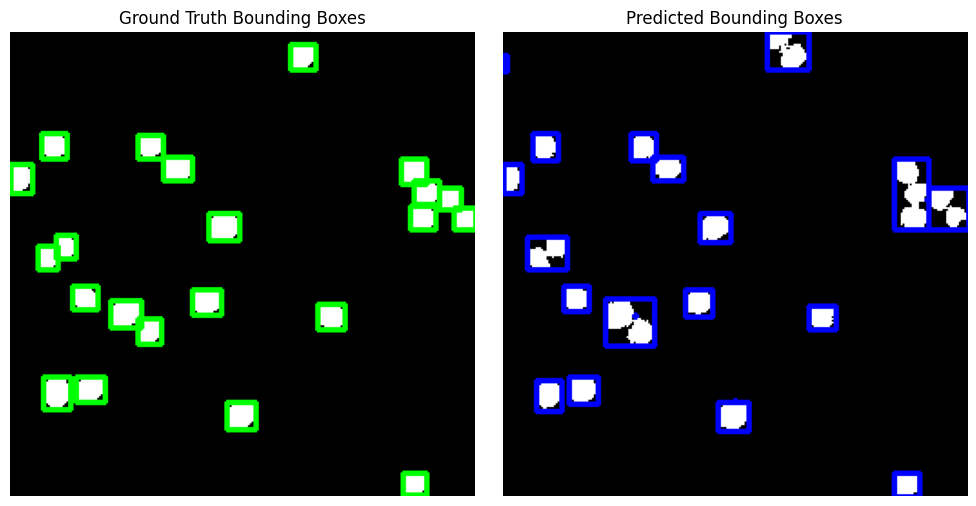

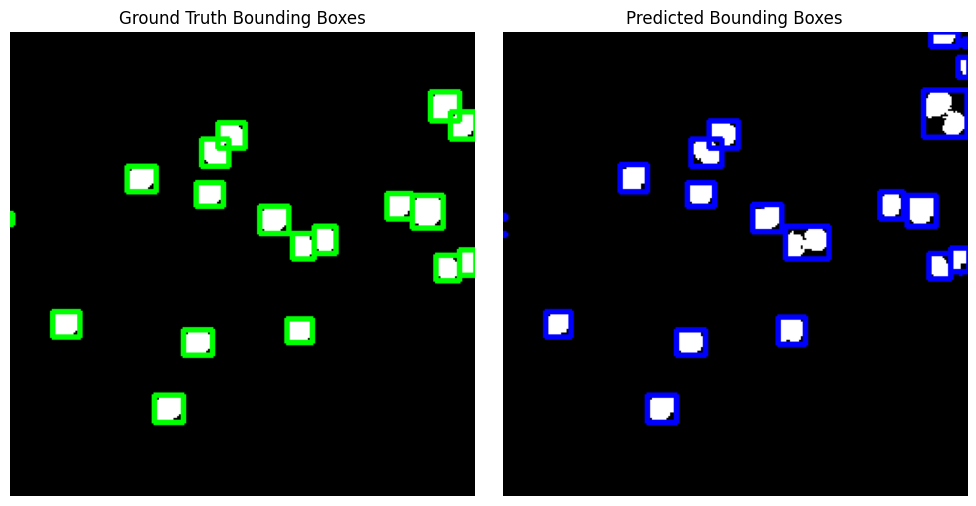

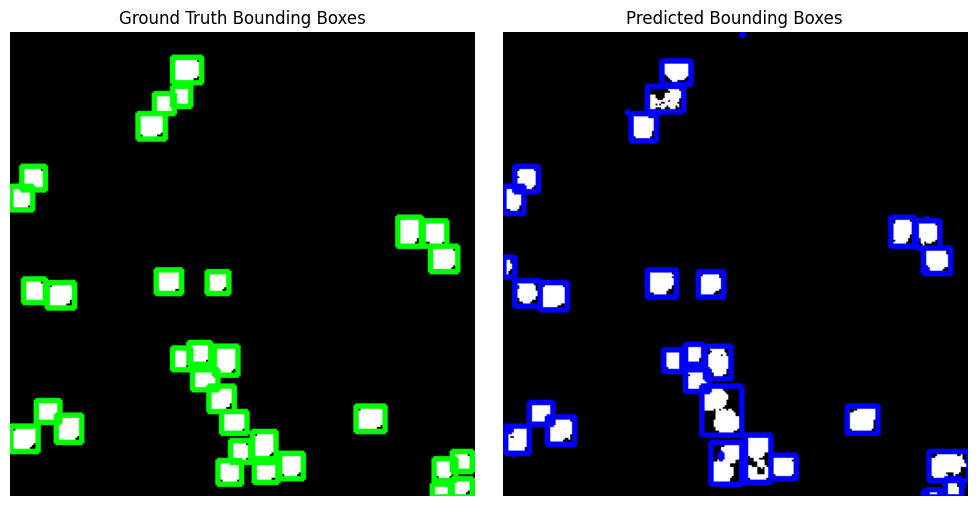

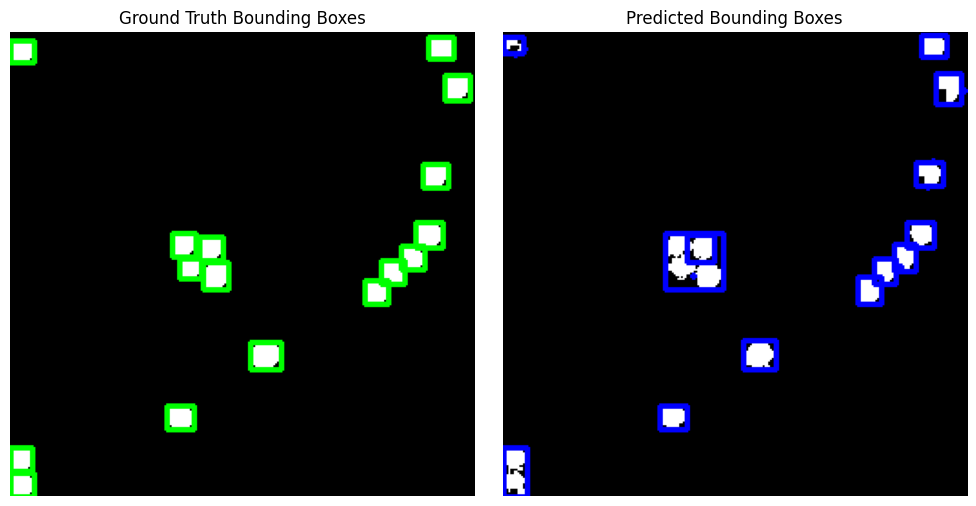

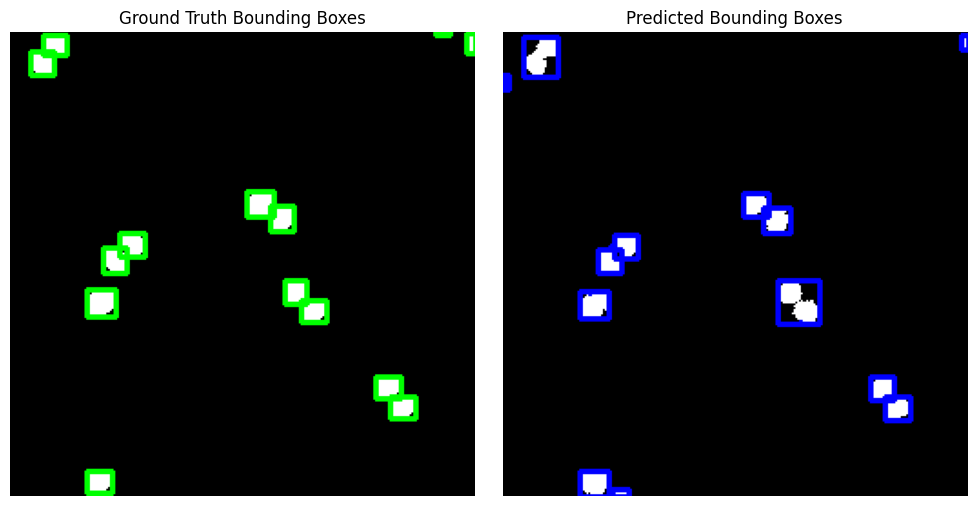

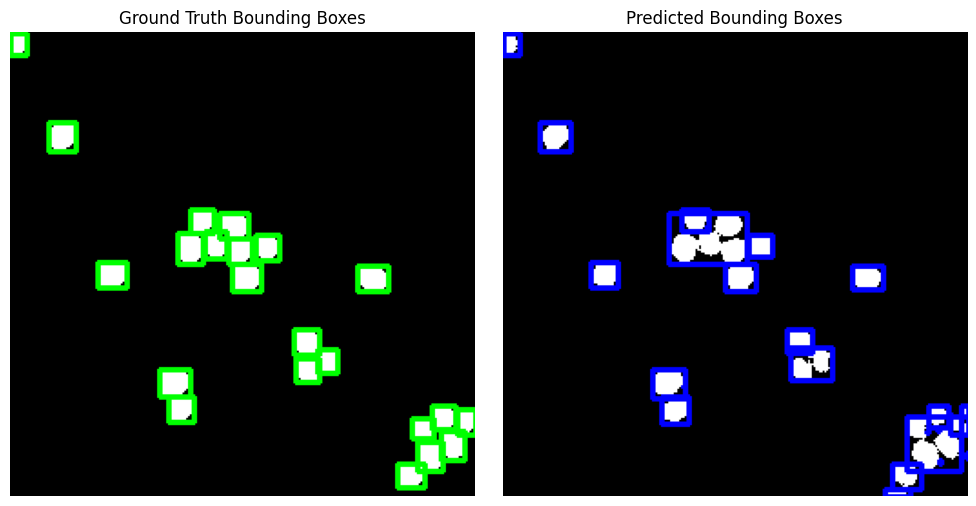

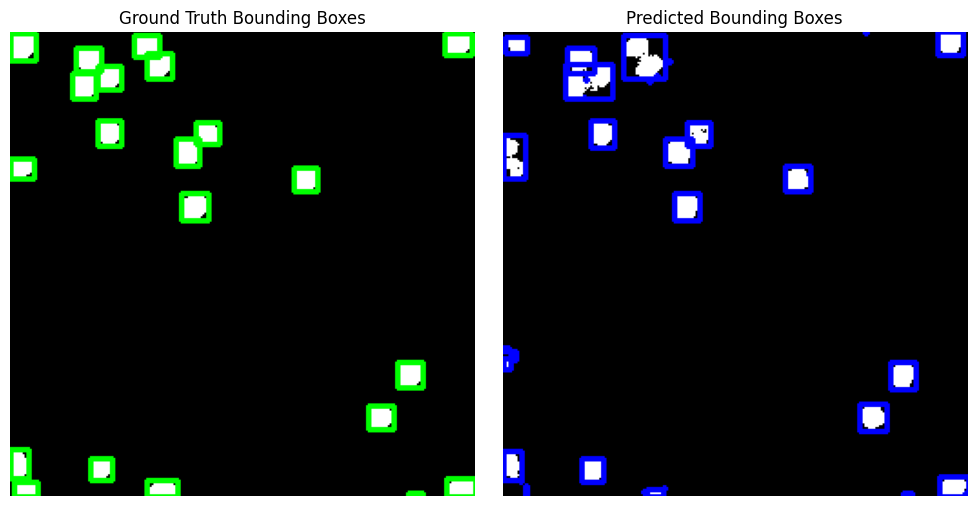

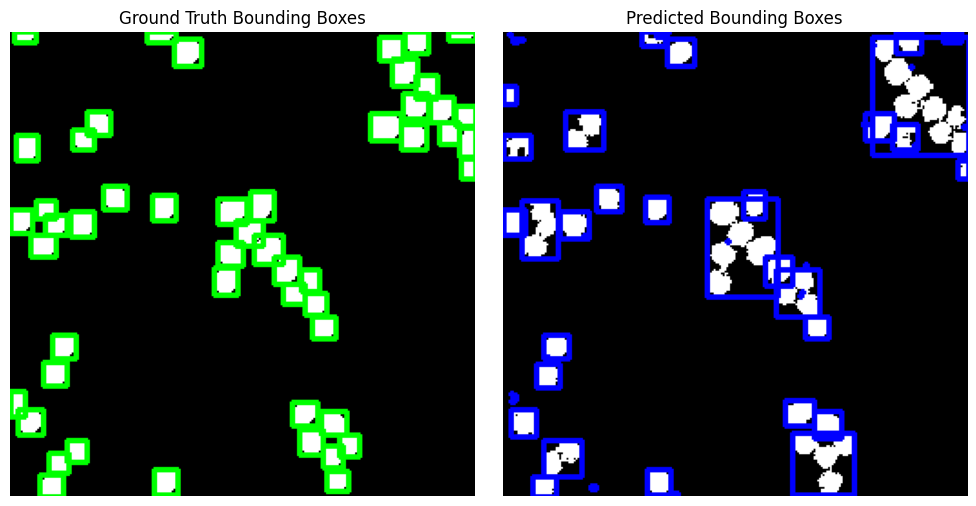

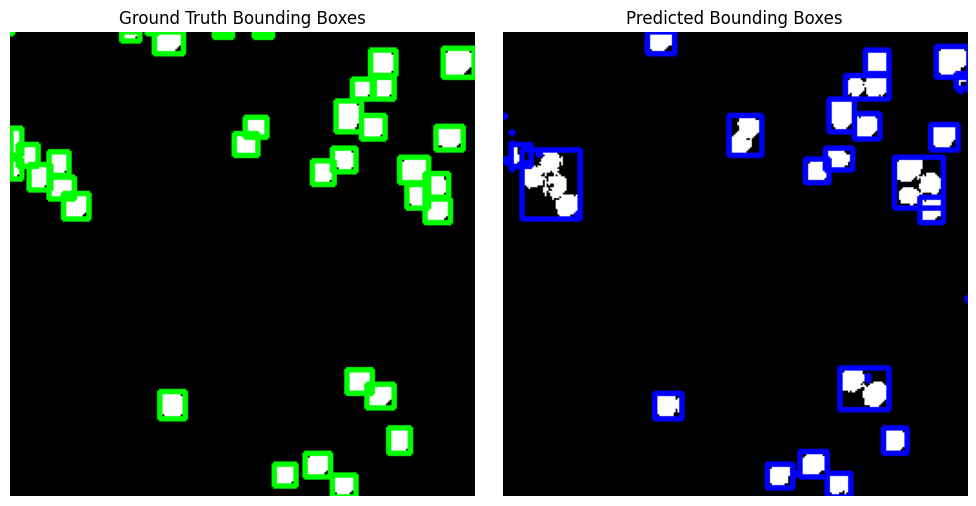

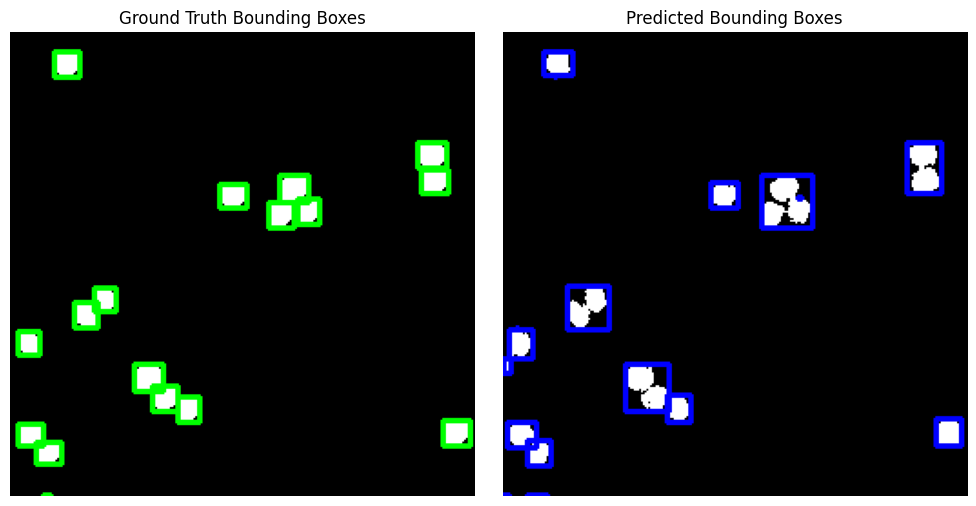

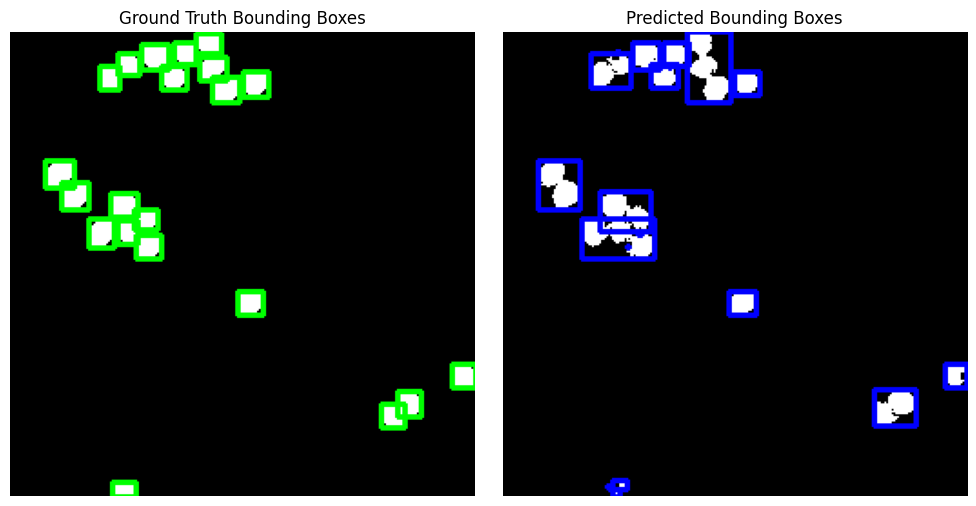

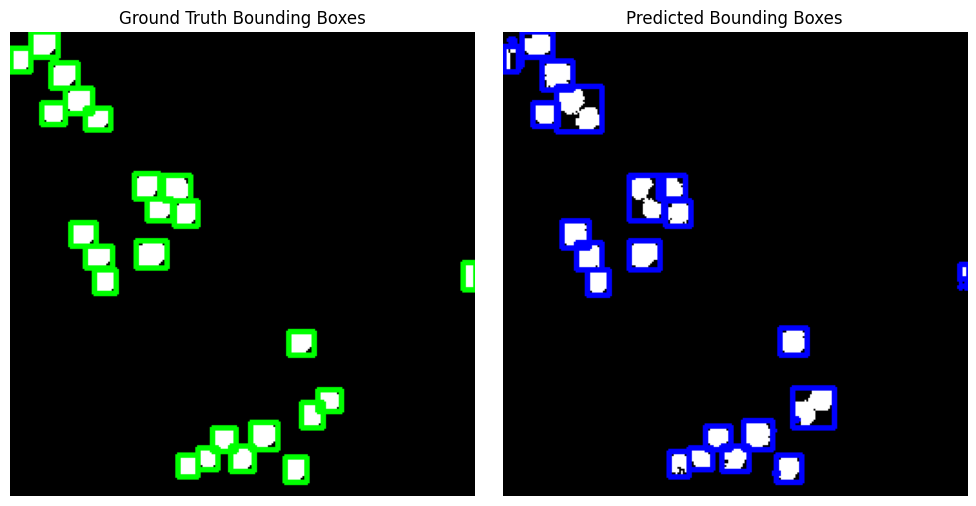

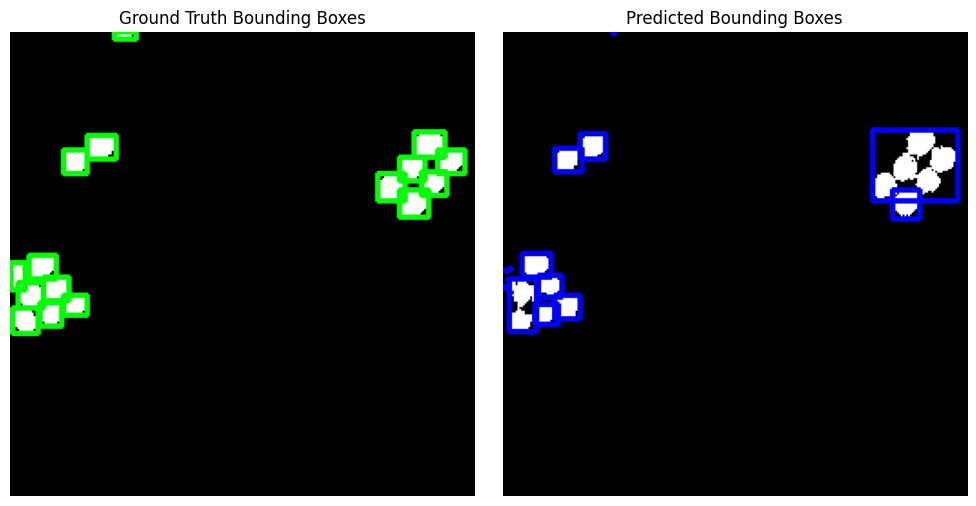

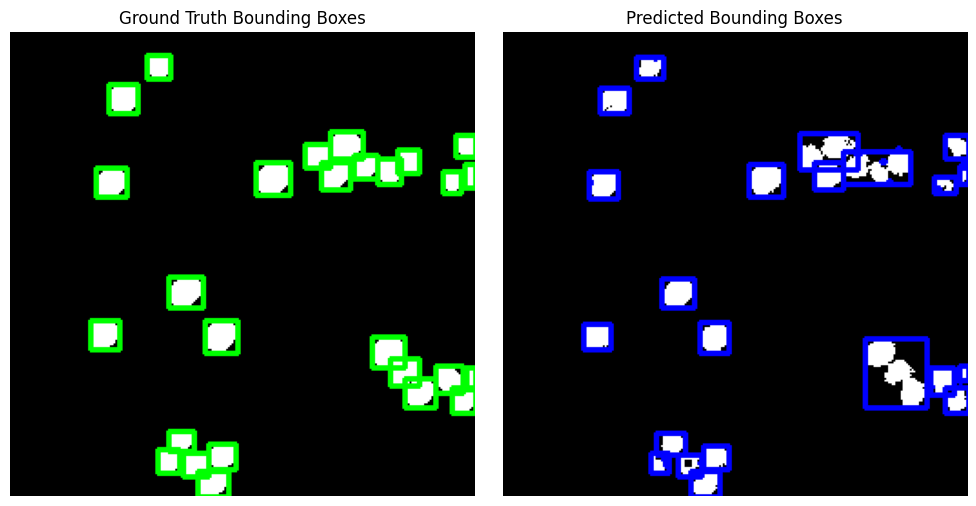

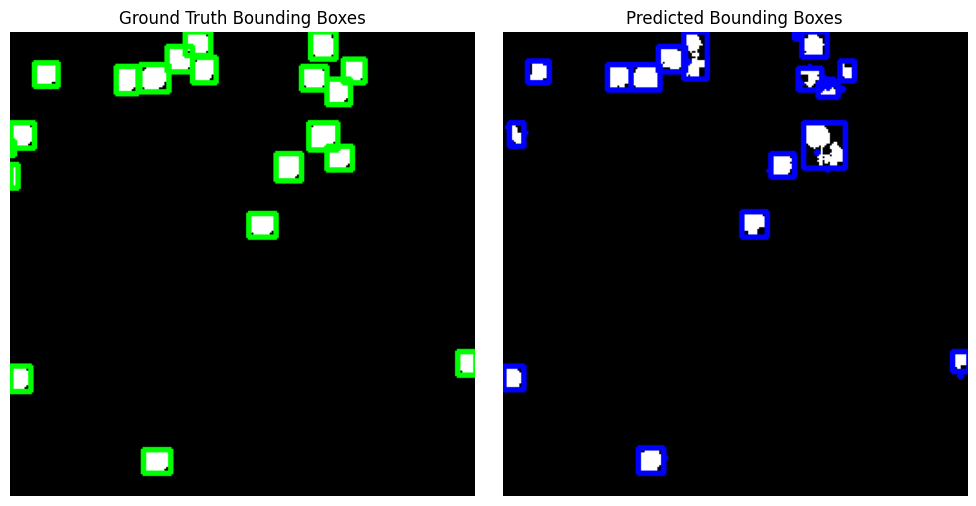

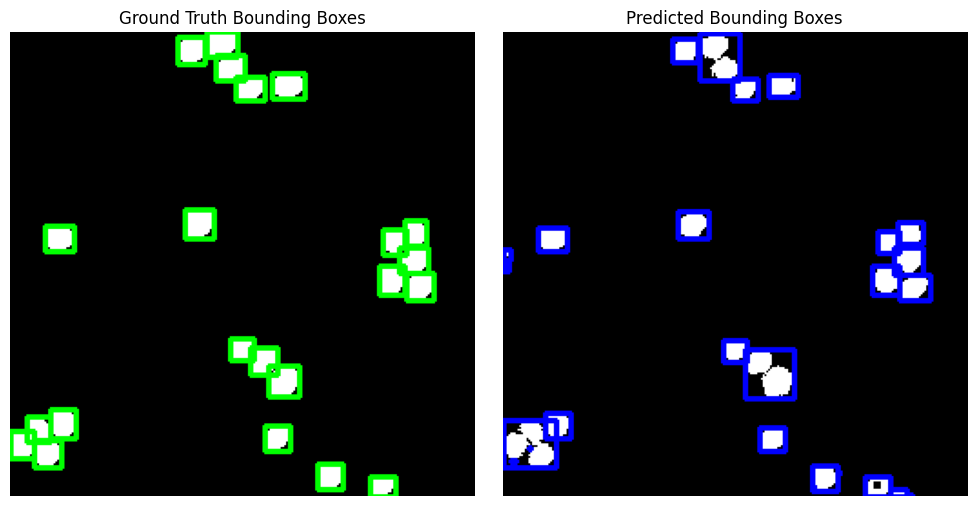

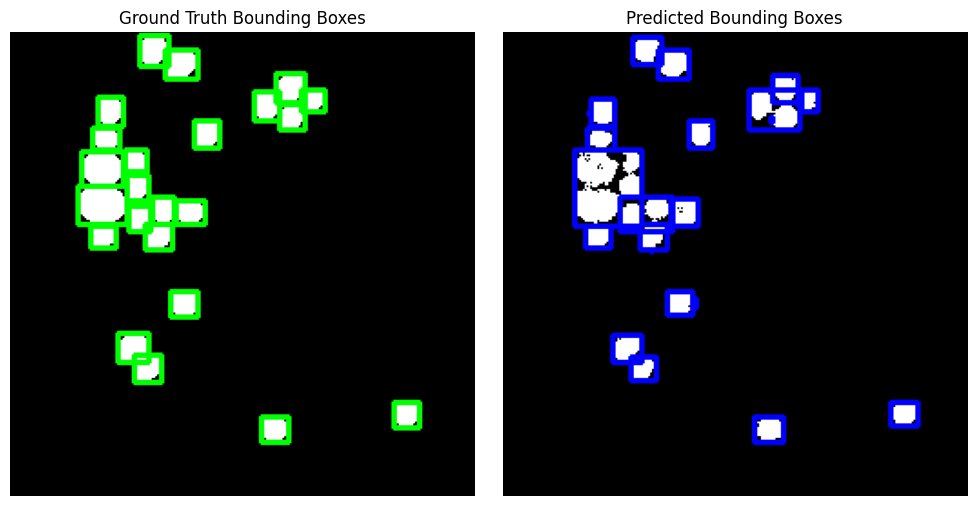

Recall: 0.6972


In [121]:
recall = calculate_recall(all_masks, all_binarized_outputs, overlap_threshold=0.75, indices_to_draw = None)
print(f"Recall: {recall:.4f}")

In [94]:
print(all_bin_masks.shape)
print(all_outputs.shape)

torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])


## HOUGH CIRCLE DETECTION

In [154]:
def get_circles(mask, dp=1, min_dist=10, param1=50, param2=30, min_radius=5, max_radius=30):
    """
    Extract circles from a binary mask using the Hough Circle Transform.
    Input:
        mask: Binary mask (H x W), where objects are white (1) and background is black (0).
        dp: Inverse ratio of the accumulator resolution to the image resolution.
        min_dist: Minimum distance between the centers of detected circles.
        param1: Upper threshold for the Canny edge detector.
        param2: Threshold for center detection in the Hough Circle Transform.
        min_radius: Minimum circle radius.
        max_radius: Maximum circle radius.
    Output:
        List of circles as (x_center, y_center, radius).
    """
    # Ensure binary format and convert to uint8
    if isinstance(mask, torch.Tensor):
        mask = mask.squeeze(0).cpu().numpy().astype(np.uint8)
    # mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR) if len(mask.shape) == 2 else mask
    # plt.imshow(mask[:,:,0])
    # plt.show
    # print(f'mask shape:', mask.shape)
    
    # Detect circles using Hough Transform
    circles = cv2.HoughCircles(
        mask,
        cv2.HOUGH_GRADIENT,
        dp=dp,
        minDist=min_dist,
        param1=param1,
        param2=param2,
        minRadius=min_radius,
        maxRadius=max_radius
    )
    print(f'Circles Shape: ', np.array(circles).shape)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        return [(x, y, r) for x, y, r in circles]
    return []

def draw_circles(image, circles, indices_to_draw=None, color=(0, 255, 0), thickness=2):
    """
    Draw specific circles on an image.
    Input:
        image: Input mask or image as numpy array (H x W).
        circles: List of circles [(x, y, r)].
        indices_to_draw: List of indices of circles to be drawn (e.g., [0, 2, 3]).
                         If None, draw all circles.
        color: Circle color (BGR for OpenCV).
        thickness: Line thickness of the circles.
    Output:
        Image with specified circles drawn.
    """
    image = image.copy()
    if len(image.shape) == 2:  # If grayscale, convert to 3-channel
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Draw only specified circles
    if indices_to_draw is None:
        indices_to_draw = range(len(circles))  # Draw all circles if none specified
    
    for idx in indices_to_draw:
        if idx < len(circles):  # Ensure index is within bounds
            x, y, r = circles[idx]
            cv2.circle(image, (x, y), r, color, thickness)
    return image


def compute_circle_overlap(circleA, circleB):
    """
    Compute the overlap between two circles.
    Each circle is (x_center, y_center, radius).
    """
    xA, yA, rA = circleA
    xB, yB, rB = circleB

    # Distance between circle centers
    d = np.sqrt((xA - xB)**2 + (yA - yB)**2)
    
    # If circles do not overlap
    if d >= rA + rB:
        return 0.0
    
    # If one circle is completely inside the other
    if d <= abs(rA - rB):
        return np.pi * min(rA, rB)**2 / (np.pi * rA**2)
    
    # Overlapping area calculation
    rA2, rB2 = rA**2, rB**2
    part1 = rA2 * np.arccos((d**2 + rA2 - rB2) / (2 * d * rA))
    part2 = rB2 * np.arccos((d**2 + rB2 - rA2) / (2 * d * rB))
    part3 = 0.5 * np.sqrt((-d + rA + rB) * (d + rA - rB) * (d - rA + rB) * (d + rA + rB))
    intersection = part1 + part2 - part3

    return intersection / (np.pi * rA**2)


def calculate_recall(all_masks, all_outputs, overlap_threshold=0.75, indices_to_draw = None):
    """
    Calculate recall and visualize bounding circles.
    Input:
        all_masks: Tensor of ground truth masks, shape [N, 1, H, W].
        all_outputs: Tensor of predicted masks, shape [N, 1, H, W].
        overlap_threshold: IoU threshold for TP.
    Output:
        Recall value and visualization of bounding circles.
    """
    total_TP = 0
    total_GT_circles = 0

    for idx, (gt_mask, pred_mask) in enumerate(zip(all_masks, all_outputs)):
        # Get Instance Masks 
        instance_masks = get_instance_masks(gt_mask)
        plt.imshow(gt_mask.squeeze())
        plt.show
        
        gt_circles_masks = []
        for mask in range(len(instance_masks)):
            circles_mask = get_circles(instance_masks[mask])
            if circles_mask:
                gt_circles_masks.append(circles_mask)
            
        gt_circles_masks = np.array(gt_circles_masks).squeeze(1)
        gt_circles = gt_circles_masks        
        # gt_circles = get_circles(gt_mask)
        # Get circles from masks
        pred_circles = get_circles(pred_mask)
        
        total_GT_circles += len(gt_circles)
        matched = set()

        # Match predicted circles to ground truth circles
        for i, gt_circle in enumerate(gt_circles):
            for j, pred_circle in enumerate(pred_circles):
                if j not in matched:
                    iou = compute_circle_overlap(gt_circle, pred_circle)
                    if iou >= overlap_threshold:
                        total_TP += 1
                        matched.add(j)
                        break

        # Visualization
        gt_image = (gt_mask > 0.5).float().squeeze().cpu().numpy().astype(np.uint8) * 255
        pred_image = pred_mask.squeeze().cpu().numpy().astype(np.uint8) * 255
        
        gt_with_circles = draw_circles(gt_image, gt_circles, indices_to_draw=indices_to_draw, color=(0, 255, 0))  # Green
        pred_with_circles = draw_circles(pred_image, pred_circles, indices_to_draw=indices_to_draw, color=(0, 0, 255))  # Red

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(gt_with_circles)
        axes[0].set_title("Ground Truth Circles")
        axes[0].axis("off")
        
        axes[1].imshow(pred_with_circles)
        axes[1].set_title("Predicted Circles")
        axes[1].axis("off")
        
        plt.tight_layout()
        plt.show()

    recall = total_TP / total_GT_circles if total_GT_circles > 0 else 0.0
    return recall


Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shape:  ()
Circles Shap

AxisError: axis 1 is out of bounds for array of dimension 1

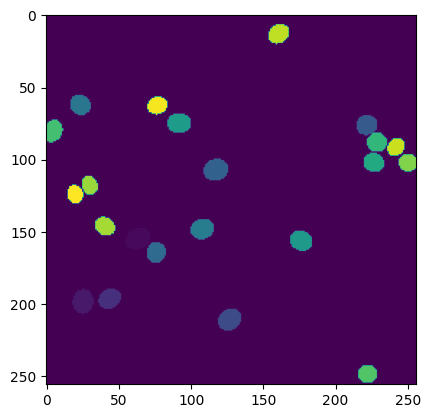

In [155]:
recall = calculate_recall(all_masks, all_binarized_outputs, overlap_threshold=0.75, indices_to_draw = None)
print(f"Recall: {recall:.4f}")